In [295]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa import stattools

from methods import get_autoregrmatrix

%matplotlib inline

In [296]:
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")
data = data[["aqi", "Date"]]
data = data.set_index('Date').sort_index()

In [297]:
x_train = data["aqi"]['2013-01-01':'2018-01-01']
x_test = data["aqi"]['2018-01-02':'2020-12-31']

Для наглядности нарисуем данные за последние два года в x_train.

<AxesSubplot: xlabel='Date'>

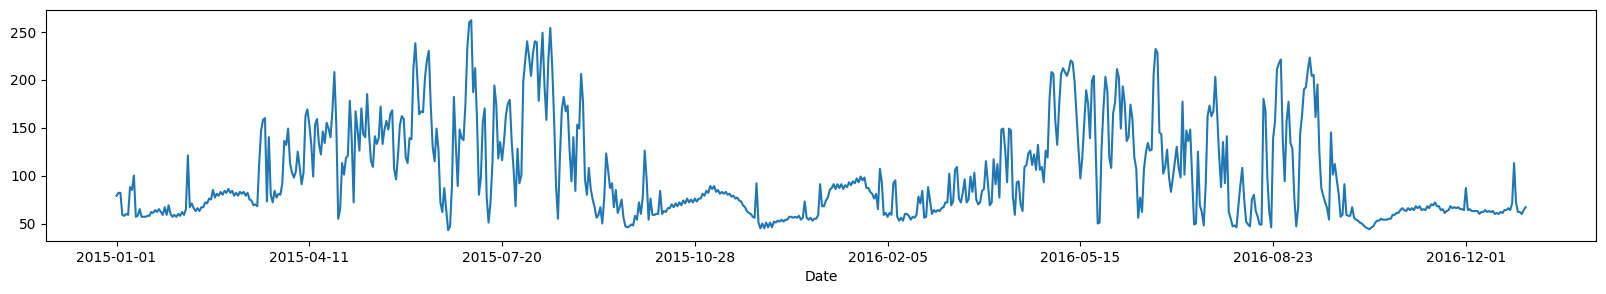

In [298]:
x_train['2015-01-01':'2017-01-01'].plot(figsize=(20, 3))

### Напишем функцию для предсказания индекса качества воздуха. Для предсказания на n дней вперёд, будем брать среднее за n дней по имеющимся у нас данным. Это будет наш Baseline.

In [299]:
# Baseline mean value for n steps behind
def mean_value_predict(data, x_test, steps):
    mean_value = int(data.tail(steps).mean())
    return x_test[:steps], np.stack([mean_value for _ in range(steps)])

Измерим ошибку за 10, 30, 60 дней.

In [300]:
y_test, y_predict = mean_value_predict(data, x_test, 10)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 126.6', 'MAE: 8.6')

In [301]:
y_test, y_predict = mean_value_predict(data, x_test, 30)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 136.86666666666667', 'MAE: 10.4')

In [302]:
y_test, y_predict = mean_value_predict(data, x_test, 60)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 126.85', 'MAE: 9.083333333333334')

Можно отметить, что ошибка не сильно возрастает со временем.

### Попробуем обучить LinearRegression. В качестве регрессоров будем брать значения за предыдущие 10 дней, каждый раз сдвигая день на 1.

In [303]:
# Пример матрицы
example_reg_matrix, _ = get_autoregrmatrix(x_train, 10, 10)
example_reg_matrix[:10]

array([[125,  79,  67,  62,  57,  55,  55,  56,  54,  64],
       [ 79,  67,  62,  57,  55,  55,  56,  54,  64,  52],
       [ 67,  62,  57,  55,  55,  56,  54,  64,  52,  51],
       [ 62,  57,  55,  55,  56,  54,  64,  52,  51,  53],
       [ 57,  55,  55,  56,  54,  64,  52,  51,  53,  61],
       [ 55,  55,  56,  54,  64,  52,  51,  53,  61,  66],
       [ 55,  56,  54,  64,  52,  51,  53,  61,  66,  71],
       [ 56,  54,  64,  52,  51,  53,  61,  66,  71,  72],
       [ 54,  64,  52,  51,  53,  61,  66,  71,  72,  71],
       [ 64,  52,  51,  53,  61,  66,  71,  72,  71,  71]])

In [304]:
def linear_regression_predict(x_train, x_test, delay, regressors=10):
    K = regressors
    h = delay # delay (горизонn прогнозирования)

    X_train, y_train = get_autoregrmatrix(x_train,h,K)
    X_test, y_test = get_autoregrmatrix(x_test,h,K)
    
    linear_regression = LinearRegression()
    linear_regression.fit(X_train,y_train)
    linear_regression_predict = linear_regression.predict(X_test)
    
    return y_test[:delay], linear_regression_predict[:delay]

Обучим LinearRegression и Измерим ошибку за 10, 30, 60 дней.

In [305]:
y_test, y_predict = linear_regression_predict(x_train, x_test, 10)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 56.94154008065668', 'MAE: 7.3549839379020625')

In [306]:
y_test, y_predict = linear_regression_predict(x_train, x_test, 30)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 63.00752430797965', 'MAE: 5.600516650634302')

In [307]:
y_test, y_predict = linear_regression_predict(x_train, x_test, 60)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 3086.469276626574', 'MAE: 44.11612227443002')

In [308]:
from copy import deepcopy

from scipy import stats

x_train = data['2013-01-01':'2018-01-01']
x_test = data['2013-01-02':'2018-01-01']
boxcox_x_train = deepcopy(x_train)

_, lmbda = stats.boxcox(x_train["aqi"])

<AxesSubplot: xlabel='Date'>

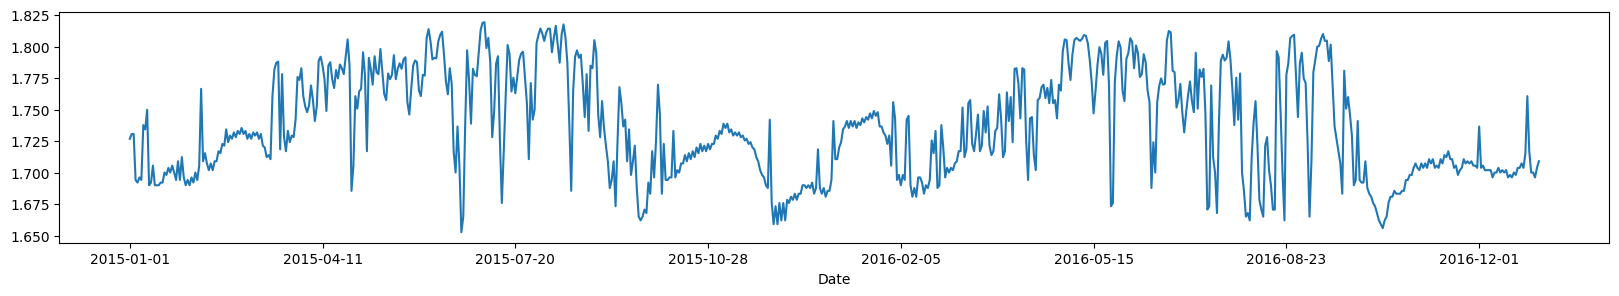

In [309]:
boxcox_x_train["box_cox_aqi"] = stats.boxcox(x_train['aqi'])[0]
boxcox_x_train['2015-01-01':'2017-01-01']["box_cox_aqi"].plot(figsize=(20, 3))

In [310]:
# seasonal differencing
# boxcox_x_train["box_cox_aqi"] = np.log(x_train['aqi'])
p = 365

sdiff_boxcox_x_train = (boxcox_x_train['box_cox_aqi'] - boxcox_x_train['box_cox_aqi'].shift(p))[p:]

In [311]:
# Augmented Dickey-Fuller unit root test
# H0: ts is not stationary
df_stat = stattools.adfuller(np.array(sdiff_boxcox_x_train))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -6.529041, 
pvalue: 0.00 
maximal Lag: 22 
critical values: {'1%': -3.4349024693573584, '5%': -2.8635506057382325, '10%': -2.5678404322793846}


In [312]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(sdiff_boxcox_x_train))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.656836, 
pvalue: 0.02 
maximal Lag: 21 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


После статтестов, можем сделать вывод, что временной ряд стационарен.

In [313]:
model_sarimax = sm.tsa.statespace.SARIMAX(boxcox_x_train["box_cox_aqi"] , order=(3, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(disp=-1)

/home/dmitry/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/dmitry/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [318]:
print(model_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        box_cox_aqi   No. Observations:                 1827
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 12)   Log Likelihood                4297.021
Date:                            Fri, 23 Dec 2022   AIC                          -8584.042
Time:                                    23:05:46   BIC                          -8556.493
Sample:                                01-01-2013   HQIC                         -8573.880
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1800      0.016    -11.006      0.000      -0.212      -0.148
ar.L2         -0.2446      0.017   

Autocorrelation test

/home/dmitry/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


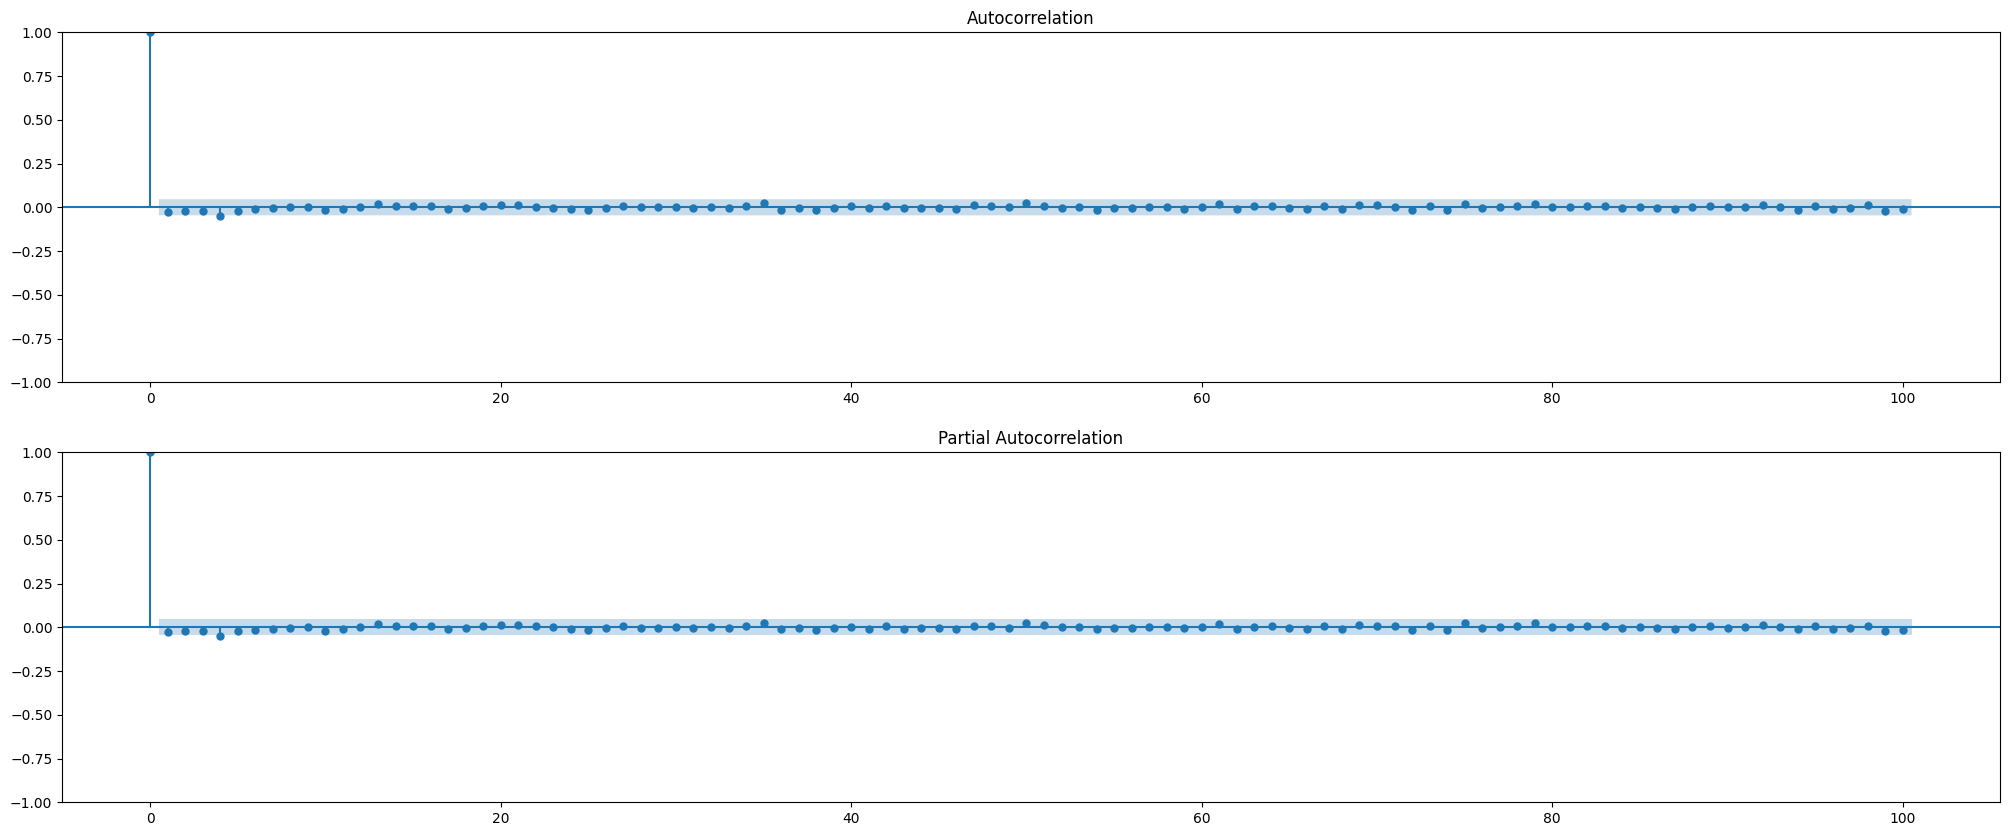

In [319]:
fig = plt.figure(figsize=[25,10])
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_sarimax.resid.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_sarimax.resid.values.squeeze(), lags=100, ax=ax2)

In [320]:
# # Ljung-Box test 
sm.stats.acorr_ljungbox(model_sarimax.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,8.414227,0.588444


lb_pvalue - Остатки распределяются независимо.

Измерим ошибку за 10, 30, 60 дней.

In [321]:
def sarima_forecast(model, steps):
    from statsmodels.base.transform import BoxCox
    predict = model.get_forecast(steps + 1).summary_frame(alpha=0.05).shift(periods=-1)
    box_cox = BoxCox()
    return pd.DataFrame(box_cox.untransform_boxcox(predict["mean"][:steps], lmbda)).values

In [322]:
sarima_predict_10 = sarima_forecast(model_sarimax, 10)
sarima_predict_30 = sarima_forecast(model_sarimax, 30)
sarima_predict_60 = sarima_forecast(model_sarimax, 60)

In [323]:
y_test_10 = data['2018-01-02':'2020-12-31'][:10]["aqi"].values
y_test_30 = data['2018-01-02':'2020-12-31'][:30]["aqi"].values
y_test_60 = data['2018-01-02':'2020-12-31'][:60]["aqi"].values

In [324]:
f"MSE: {mean_squared_error(y_test_10, sarima_predict_10)}", f"MAE: {mean_absolute_error(y_test_10, sarima_predict_10)}"

('MSE: 35.56345402468726', 'MAE: 4.367178034324879')

In [325]:
f"MSE: {mean_squared_error(y_test_30, sarima_predict_30)}", f"MAE: {mean_absolute_error(y_test_30, sarima_predict_30)}"

('MSE: 66.51948114364343', 'MAE: 6.934127003735174')

In [326]:
f"MSE: {mean_squared_error(y_test_60, sarima_predict_60)}", f"MAE: {mean_absolute_error(y_test_60, sarima_predict_60)}"

('MSE: 297.25472791356566', 'MAE: 13.692983316299879')

In [327]:
x_train = data["aqi"]['2013-01-01':'2018-01-01']
x_test = data["aqi"]['2018-01-02':'2020-12-31']

In [328]:
def draw_compare_plot(x_train, x_test, linear_regression_predict, mean_value_predict, model_sarimax, steps):
    x_steps = np.arange(steps)
    y_test = x_test[:steps].values
    
    _, y_lin_reg_predict = linear_regression_predict(x_train, x_test, steps)
    _, y_mean_predict = mean_value_predict(x_train, x_test, steps)
    y_sarima_predict = sarima_forecast(model_sarimax, steps)

    plt.figure(figsize = (25, 5))
    plt.title(f"TS Forecast {steps} days")

    plt.xlabel('Day')
    plt.plot(x_steps, y_test, color="red", label="Test data")
    plt.plot(x_steps, y_sarima_predict, color="blue", label="Sarima")
    plt.plot(x_steps, y_lin_reg_predict, color="green", label="LinearRegression")
    plt.plot(x_steps, y_mean_predict, color="magenta", label="Mean")
    plt.legend(loc="upper right")

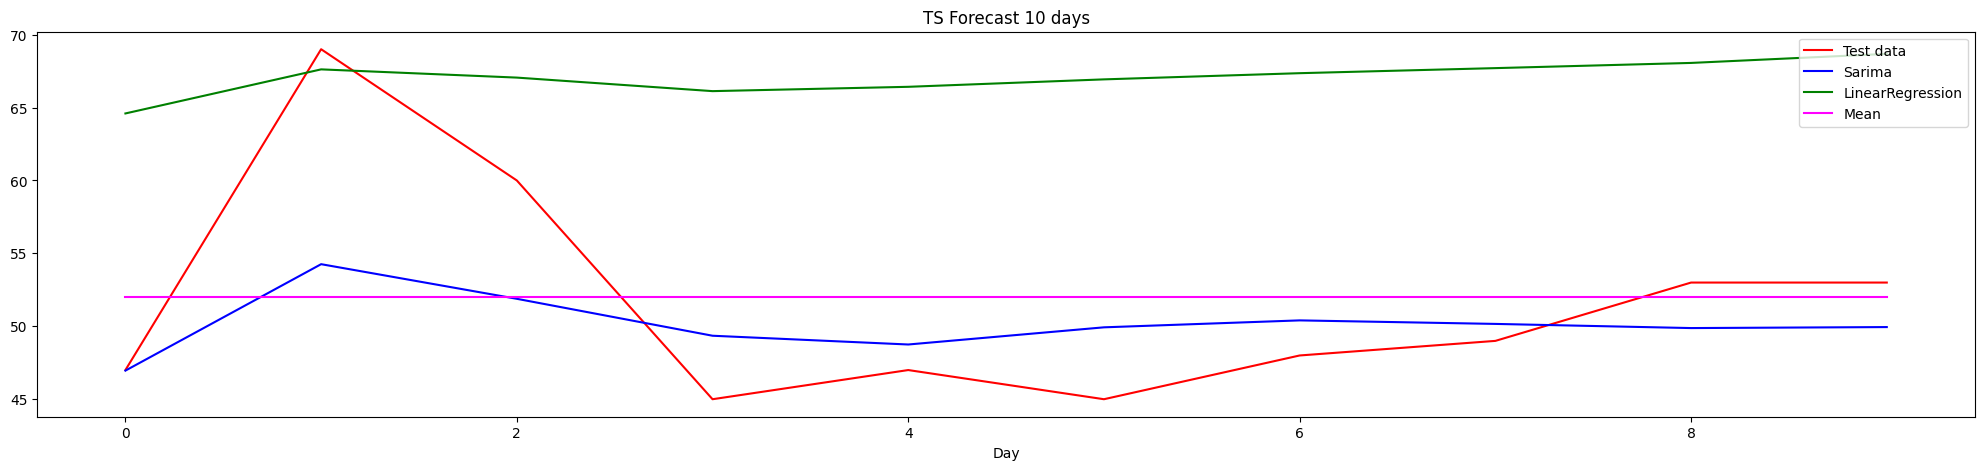

In [329]:
draw_compare_plot(x_train, x_test, linear_regression_predict, mean_value_predict, model_sarimax, 10)